In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import itertools
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))

In [0]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [0]:
def LSTM_model(train_data, test_data, look_back=1, units=4):
  trainX, trainY = create_dataset(train_data, look_back)
  testX, testY = create_dataset(test_data, look_back)
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  model = Sequential()
  model.add(LSTM(units=units, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  print('-----> look back = {l} , units = {u}'.format(l=look_back,u=units))
  model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=2)
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  train_RMSE = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  test_RMSE = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

  return [trainY[0], trainPredict[:,0], train_RMSE, testY[0], testPredict[:,0], test_RMSE]

In [0]:
original_data = np.genfromtxt('DAT_MT_EURUSD_M1_2019.csv', delimiter=',')
original_data = original_data[1::60, 2]
length_data = len(original_data)

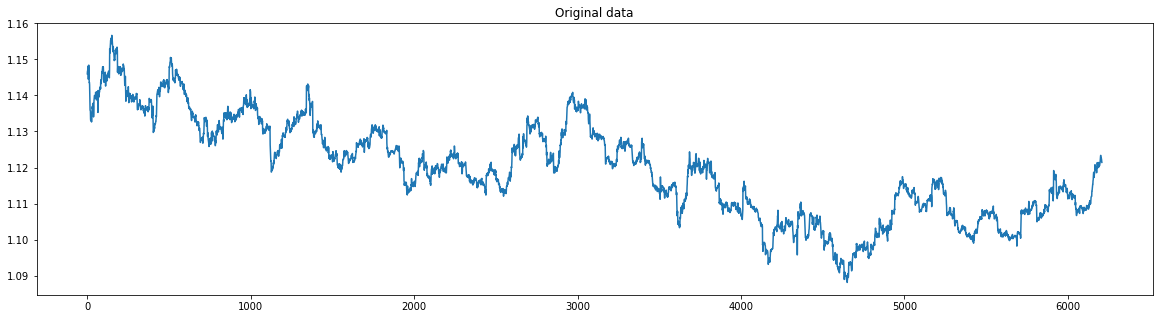

In [0]:
plt.figure(figsize=(20,5))
plt.title('Original data')
plt.plot(original_data)

In [0]:
train_data = original_data[:int(10/12*length_data)]
train_data = train_data.reshape((len(train_data), 1))
test_data = original_data[int(10/12*length_data):]
test_data = test_data.reshape((len(test_data), 1))

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

In [0]:
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (5174, 1)
Shape of test data: (1035, 1)


In [0]:
# information_LSTM:  for each key (look back, units) we have the next list:
# [trainY, trainPredict, train_RMSE, testY, testPredict, test_RMSE]

look_back = [i for i in range(5,16,5)]
units = [5,10,15] 
parameters = get_combinations([look_back, units])
information_LSTM = {}

for lb, u in parameters:
  info = LSTM_model(train_data.copy(), test_data.copy() ,lb, u)
  information_LSTM[(lb,u)] = info

-----> look back = 5 , units = 5
Epoch 1/3
 - 33s - loss: 0.0025
Epoch 2/3
 - 31s - loss: 3.6461e-04
Epoch 3/3
 - 32s - loss: 3.1685e-04
-----> look back = 5 , units = 10
Epoch 1/3
 - 32s - loss: 0.0033
Epoch 2/3
 - 31s - loss: 3.0675e-04
Epoch 3/3
 - 31s - loss: 2.5748e-04
-----> look back = 5 , units = 15
Epoch 1/3
 - 32s - loss: 0.0038
Epoch 2/3
 - 31s - loss: 2.5321e-04
Epoch 3/3
 - 31s - loss: 2.3215e-04
-----> look back = 10 , units = 5
Epoch 1/3
 - 32s - loss: 0.0039
Epoch 2/3
 - 32s - loss: 3.6420e-04
Epoch 3/3
 - 32s - loss: 2.9783e-04
-----> look back = 10 , units = 10
Epoch 1/3
 - 32s - loss: 0.0010
Epoch 2/3
 - 31s - loss: 3.3240e-04
Epoch 3/3
 - 31s - loss: 2.6266e-04
-----> look back = 10 , units = 15
Epoch 1/3
 - 32s - loss: 0.0019
Epoch 2/3
 - 32s - loss: 3.0682e-04
Epoch 3/3
 - 32s - loss: 2.6310e-04
-----> look back = 15 , units = 5
Epoch 1/3
 - 31s - loss: 0.0079
Epoch 2/3
 - 31s - loss: 3.9044e-04
Epoch 3/3
 - 31s - loss: 3.2126e-04
-----> look back = 15 , units = 1

In [0]:
k = (look_back[0],units[0])
min_rmse = information_LSTM[k][5]

for key in information_LSTM:
  if information_LSTM[key][5] < min_rmse:
    min_rmse=information_LSTM[key][5]
    k=key

trainY,trainPredict,train_RMSE = information_LSTM[k][0],information_LSTM[k][1],information_LSTM[k][2]
testY, testPredict, test_RMSE = information_LSTM[k][3],information_LSTM[k][4],information_LSTM[k][5]

In [0]:
print('The best parameters: look back = {l}, units={u}'.format(l=k[0], u=k[1]))
print('The best RMSE = {err}'.format(err=min_rmse))

The best parameters: look back = 5, units=15
The best RMSE = 0.0007136265977746055


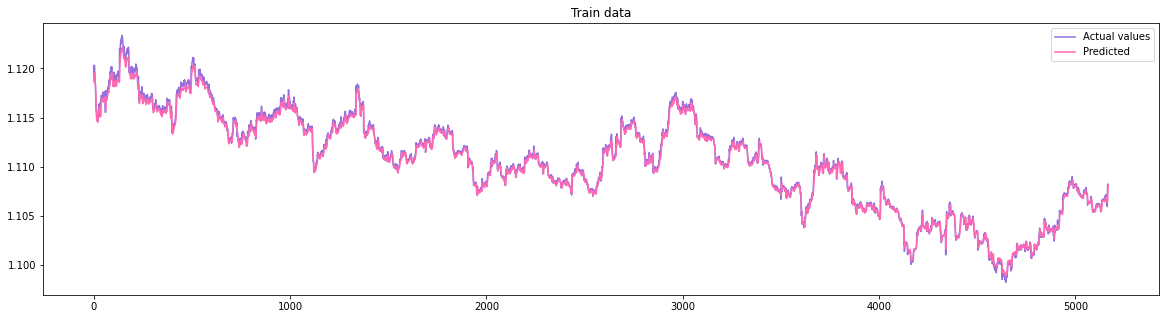

In [0]:
plt.figure(figsize=(20,5))
plt.title('Train data')
plt.plot(trainY, color='mediumpurple', label='Actual values')
plt.plot(trainPredict, color='hotpink', label='Predicted')
plt.legend(loc='best')

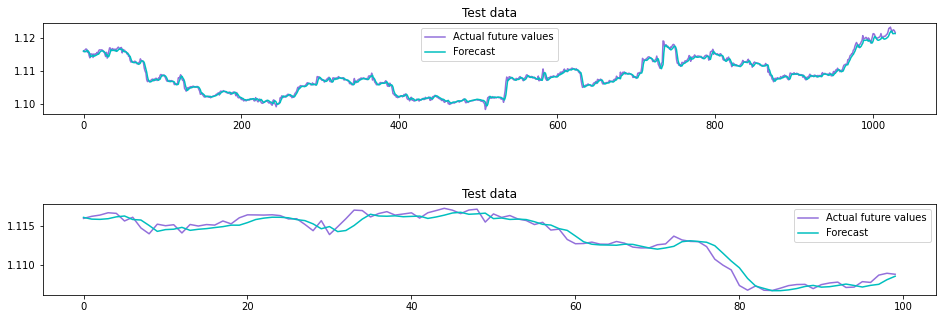

In [0]:
plt.figure(figsize=(16,5))
plt.subplot(211)
plt.title('Test data')
plt.plot(testY, color='mediumpurple', label='Actual future values')
plt.plot(testPredict, color='c', label='Forecast')
plt.legend(loc='best')
plt.subplot(212)
plt.title('Test data')
plt.plot(testY[:100], color='mediumpurple', label='Actual future values')
plt.plot(testPredict[:100], color='c', label='Forecast')
plt.legend(loc='best')
plt.subplots_adjust(hspace=1)